# Different Dataset Demos

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

import grid_distillation_lib_demo as gd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from PIL import Image

In [2]:
# print cuda devices
print("CUDA devices: ", torch.cuda.device_count())
print("CUDA device name: ", torch.cuda.get_device_name(0))

# select device and print info
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(0)

CUDA devices:  1
CUDA device name:  NVIDIA GeForce GTX 1650 Ti


_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650 Ti', major=7, minor=5, total_memory=4095MB, multi_processor_count=16)

# Demo - Digits

In [3]:

# Load the dataset
digits = load_digits()
X = digits.images
y = digits.target

# Normalize the images
X = X / 255.0

# Reshape the images to (n_samples, 1, 8, 8)
X = X.reshape(-1, 1, 8, 8)

# Convert labels to torch tensors
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train and evaluate the original model
train(model, train_loader, criterion, optimizer, epochs=10)
original_accuracy = evaluate(model, test_loader)
print(f'Original Model Accuracy: {original_accuracy}%')


Epoch [1/10], Loss: 2.3046981387668186
Epoch [2/10], Loss: 2.2988264666663274
Epoch [3/10], Loss: 2.278167872958713
Epoch [4/10], Loss: 2.143169562021891
Epoch [5/10], Loss: 1.638644560178121
Epoch [6/10], Loss: 1.1129207836257087
Epoch [7/10], Loss: 0.8453392611609565
Epoch [8/10], Loss: 0.7147224174605475
Epoch [9/10], Loss: 0.6268736614121331
Epoch [10/10], Loss: 0.5518956402937572
Original Model Accuracy: 84.16666666666667%


## Grid

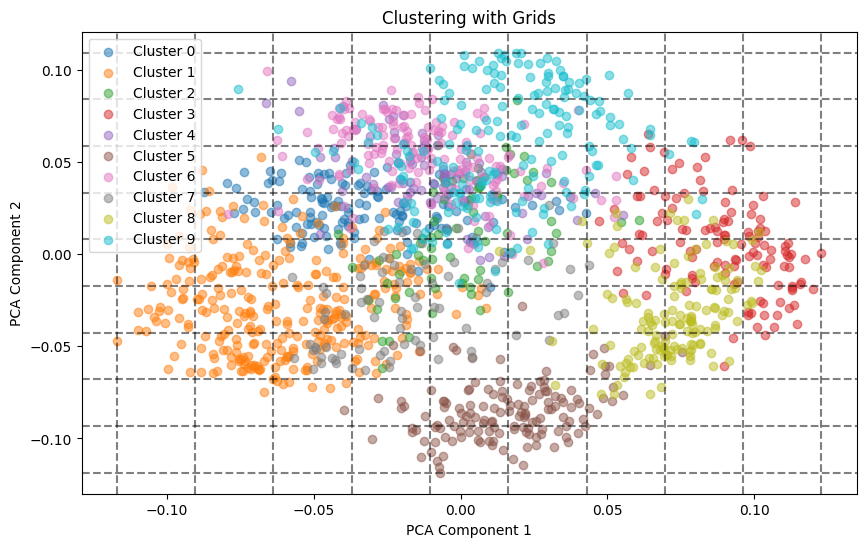

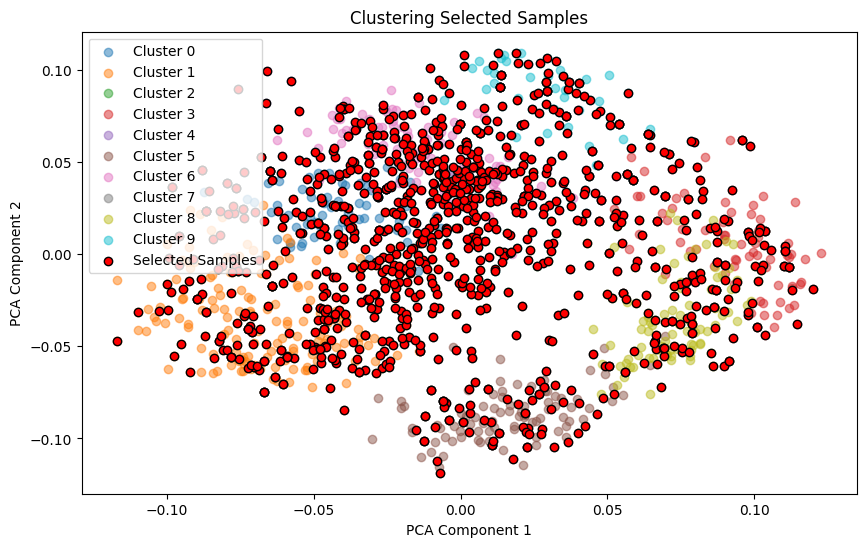

Epoch [1/10], Loss: 2.2954049327156762
Epoch [2/10], Loss: 2.2820178017471777
Epoch [3/10], Loss: 2.2785283001986416
Epoch [4/10], Loss: 2.275743181055242
Epoch [5/10], Loss: 2.2712989431439023
Epoch [6/10], Loss: 2.26562111305468
Epoch [7/10], Loss: 2.2516700571233574
Epoch [8/10], Loss: 2.2211412010770855
Epoch [9/10], Loss: 2.150849436268662
Epoch [10/10], Loss: 2.0429909265402593
Distilled Model Accuracy: 29.166666666666668%


In [4]:
grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
grid_sampler.cluster_images()
grid_sampler.plot_clusters_with_grids()
selected_samples = grid_sampler.get_selected_samples()
grid_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')

## Paralelogram

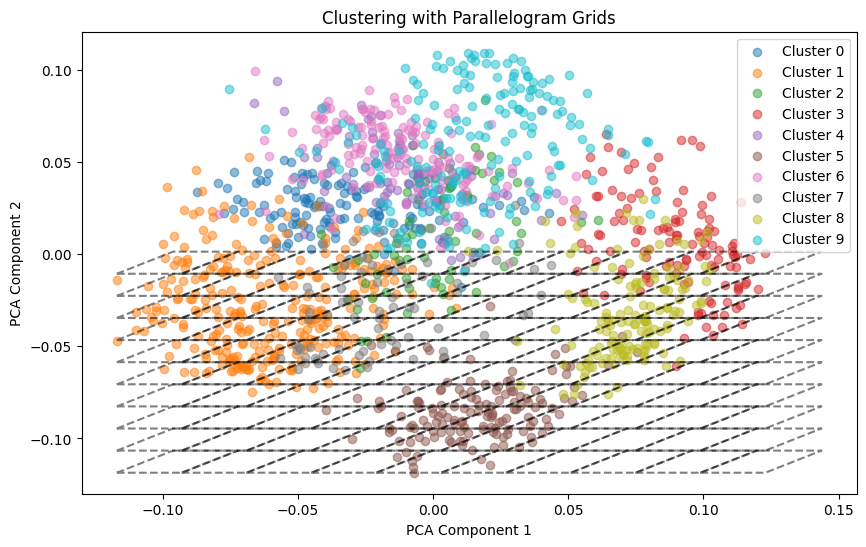

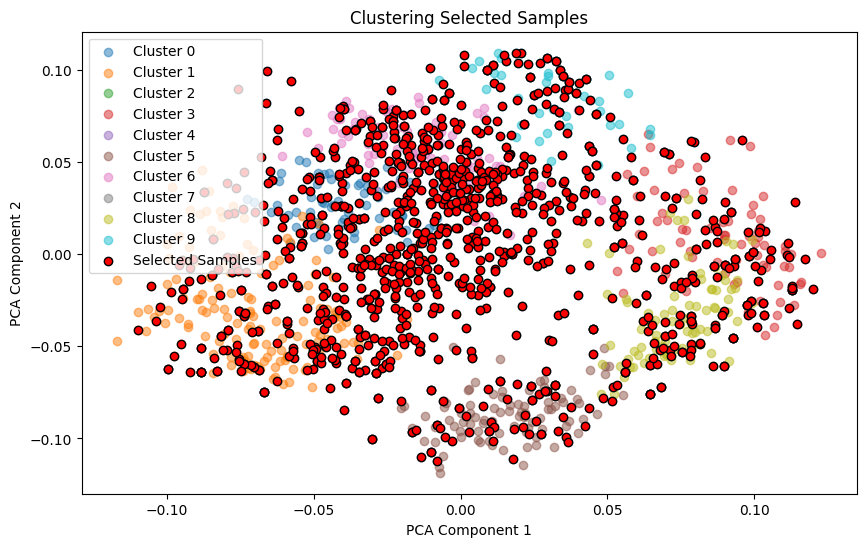

Epoch [1/10], Loss: 2.295552022529371
Epoch [2/10], Loss: 2.28230399796457
Epoch [3/10], Loss: 2.2792751355604692
Epoch [4/10], Loss: 2.2743594935446074
Epoch [5/10], Loss: 2.269557569966172
Epoch [6/10], Loss: 2.261613701329087
Epoch [7/10], Loss: 2.246754364533858
Epoch [8/10], Loss: 2.2140496933098994
Epoch [9/10], Loss: 2.1134990128603848
Epoch [10/10], Loss: 1.909962950330792
Distilled Model Accuracy: 31.666666666666668%


In [5]:

paralelogram_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
paralelogram_sampler.cluster_images()
paralelogram_sampler.plot_clusters_with_parallelograms()
selected_samples = paralelogram_sampler.get_selected_samples()
paralelogram_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')


## Triangular

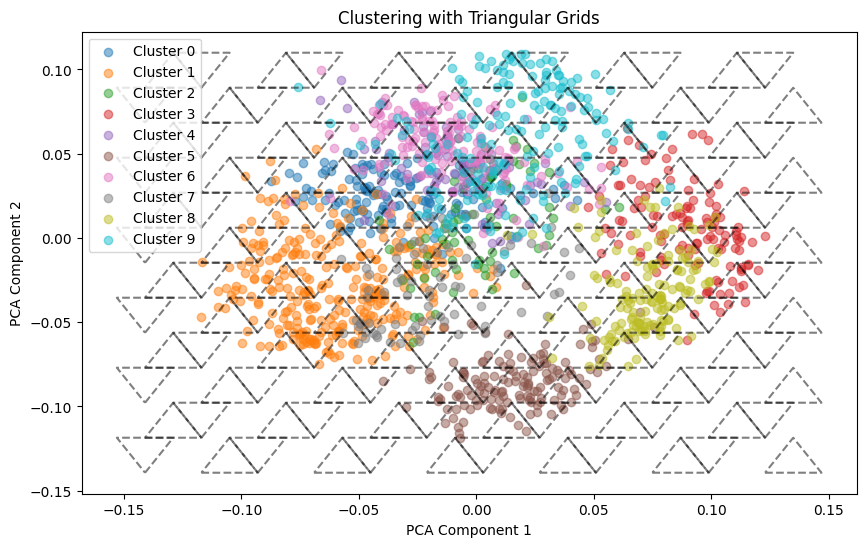

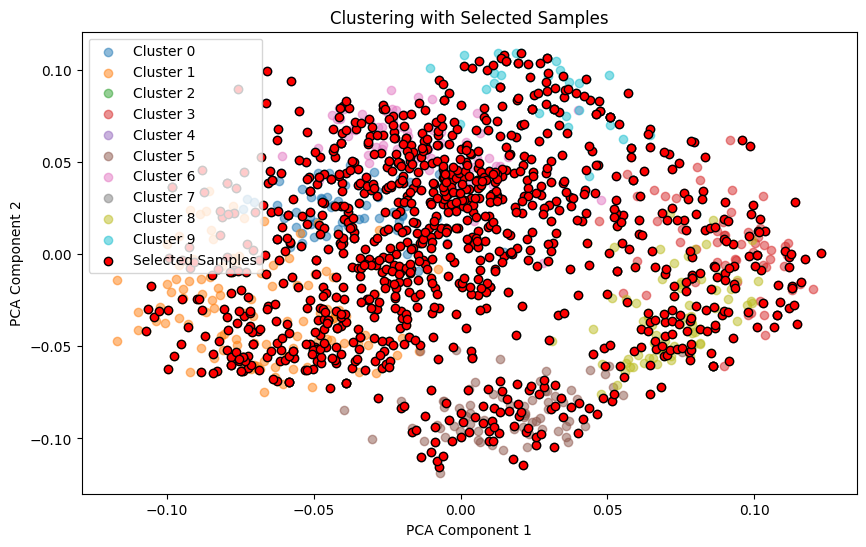

Epoch [1/10], Loss: 2.2895746664567427
Epoch [2/10], Loss: 2.279270555033828
Epoch [3/10], Loss: 2.2755280263496167
Epoch [4/10], Loss: 2.273904916011926
Epoch [5/10], Loss: 2.2672932292475845
Epoch [6/10], Loss: 2.248111746527932
Epoch [7/10], Loss: 2.208574880253185
Epoch [8/10], Loss: 2.082762010169752
Epoch [9/10], Loss: 1.8202583067344897
Epoch [10/10], Loss: 1.4669100551894216
Distilled Model Accuracy: 54.166666666666664%


In [6]:



triangle_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
triangle_sampler.cluster_images()
triangle_sampler.plot_clusters_with_triangles()
selected_samples = triangle_sampler.get_selected_samples()
triangle_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')


## Brick

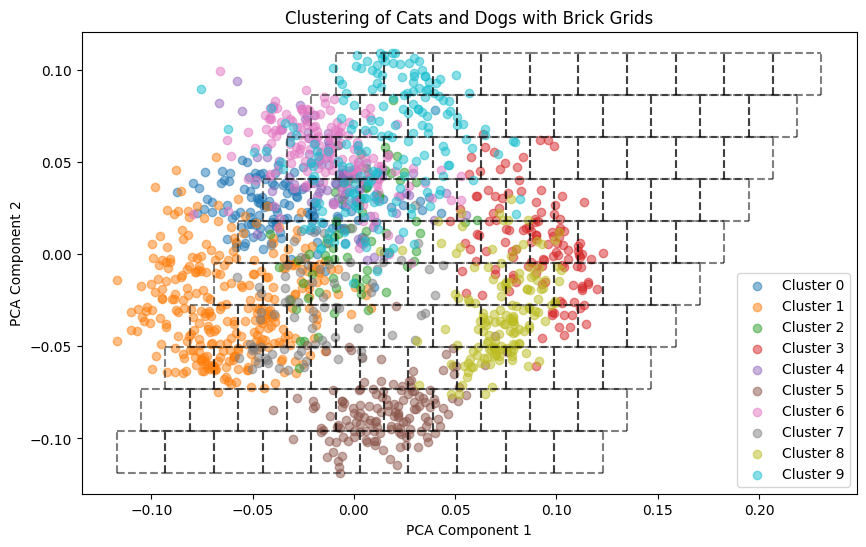

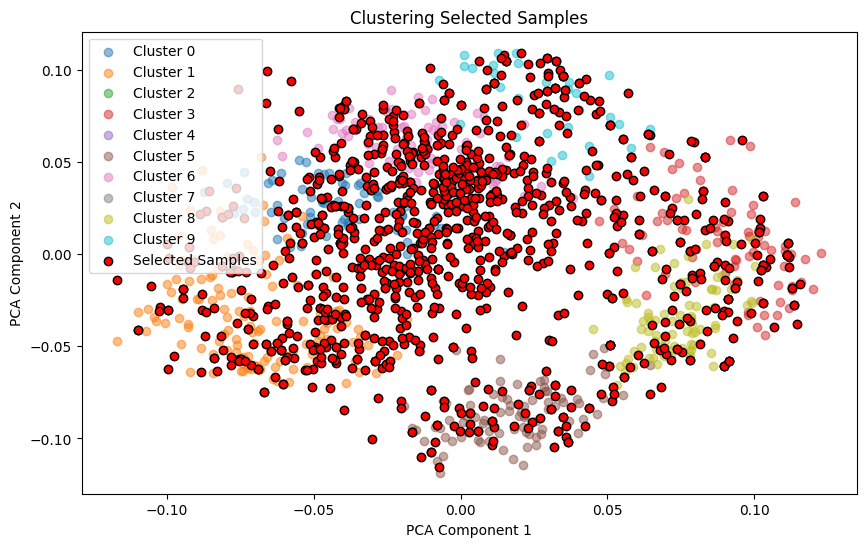

Epoch [1/10], Loss: 2.295144218387026
Epoch [2/10], Loss: 2.2795425978573887
Epoch [3/10], Loss: 2.273735205332438
Epoch [4/10], Loss: 2.2660407586531206
Epoch [5/10], Loss: 2.2470705147945518
Epoch [6/10], Loss: 2.1919327215714888
Epoch [7/10], Loss: 2.07442315419515
Epoch [8/10], Loss: 1.8994575558286724
Epoch [9/10], Loss: 1.7250653396953235
Epoch [10/10], Loss: 1.5508820902217517
Distilled Model Accuracy: 55.27777777777778%


In [7]:
brick_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
brick_sampler.cluster_images()
brick_sampler.plot_clusters_with_bricks()
selected_samples = brick_sampler.get_selected_samples()
brick_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')

# Demo - Flowers

In [8]:
# Define the list of flowers and data directory
flowers = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
data_dir = 'C:\\Users\\Hp\\summer_projects\\datasets\\flower_images'

# Load the dataset
dataset = []
for i, flower in enumerate(flowers):
    print(f'Processing {flower} images...')
    flower_dir = os.path.join(data_dir, flower)
    for file in os.listdir(flower_dir):
        image_path = os.path.join(flower_dir, file)
        image = Image.open(image_path)
        image = image.resize((128, 128))  # Resize images to (128, 128)
        dataset.append((np.array(image), i))

# Shuffle the dataset
np.random.shuffle(dataset)

# Split the dataset into images and labels
X = np.array([x[0] for x in dataset], dtype=np.float32) / 255.0
y = np.array([x[1] for x in dataset], dtype=np.int64)

# Convert images to torch tensors
X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # Reshape to (N, C, H, W)
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training function
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}')

# Define evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model
train(model, train_loader, criterion, optimizer, epochs=10)

# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Original Model Accuracy: {accuracy}%')
# 7m 34.7s - Original Model Accuracy: 85.9%

Processing Lilly images...
Processing Lotus images...
Processing Orchid images...
Processing Sunflower images...
Processing Tulip images...
Epoch 1/10, Loss: 1.2885786905288696
Epoch 2/10, Loss: 1.0179392027854919
Epoch 3/10, Loss: 0.7994979329109192
Epoch 4/10, Loss: 0.5579331452846528
Epoch 5/10, Loss: 0.3027547357082367
Epoch 6/10, Loss: 0.15094555330276488
Epoch 7/10, Loss: 0.0844664194881916
Epoch 8/10, Loss: 0.06158822751045227
Epoch 9/10, Loss: 0.03316351965907961
Epoch 10/10, Loss: 0.022244913574308158
Original Model Accuracy: 84.8%


## Grid Distillation

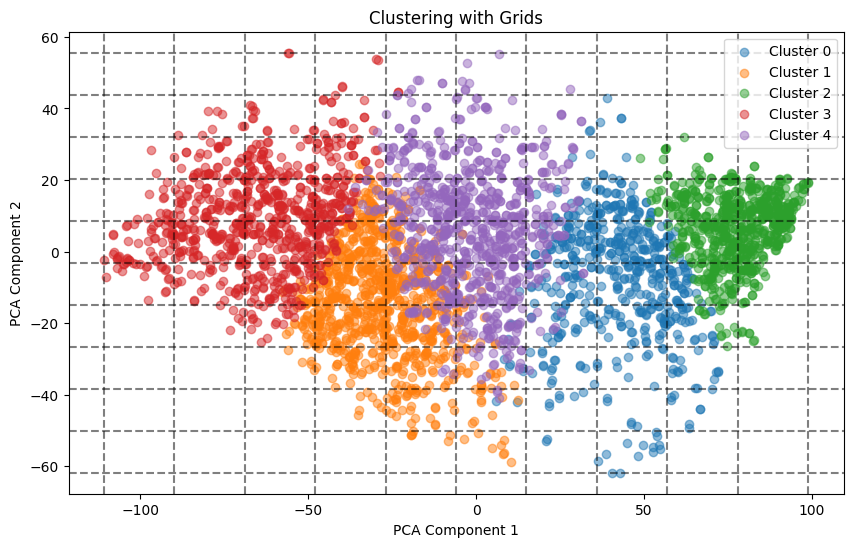

Epoch 1/10, Loss: 1.5830520963668824
Epoch 2/10, Loss: 1.2585372614860535
Epoch 3/10, Loss: 0.9734739605585734
Epoch 4/10, Loss: 0.7140337562561035
Epoch 5/10, Loss: 0.44946007649103803
Epoch 6/10, Loss: 0.22182761525114378
Epoch 7/10, Loss: 0.1026042543600003
Epoch 8/10, Loss: 0.07070195991545916
Epoch 9/10, Loss: 0.03343153071900209
Epoch 10/10, Loss: 0.03592496146874813
Distilled Model Accuracy: 72.3%


In [9]:
# Distill the model with grid distillation and evaluate
grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=5, n_samples=100)
grid_sampler.cluster_images()
grid_sampler.plot_clusters_with_grids()
selected_samples = grid_sampler.get_selected_samples()

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')
# 4m 29.3s - Distilled Model Accuracy: 71.1%


## Paralelogram Distillation

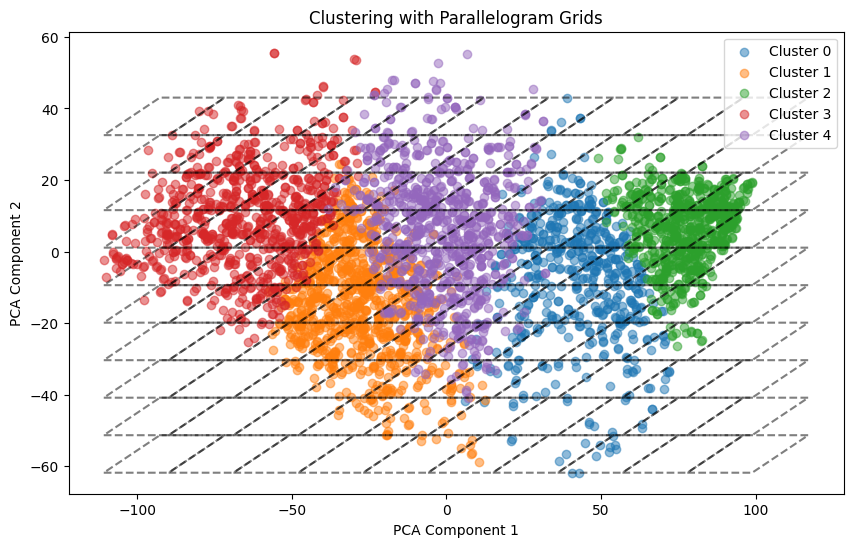

Epoch 1/10, Loss: 1.4109588909149169
Epoch 2/10, Loss: 1.1437638314565022
Epoch 3/10, Loss: 0.870530260403951
Epoch 4/10, Loss: 0.5712489608923594
Epoch 5/10, Loss: 0.31499273657798765
Epoch 6/10, Loss: 0.15636560027798016
Epoch 7/10, Loss: 0.11569491437325875
Epoch 8/10, Loss: 0.07956761070759967
Epoch 9/10, Loss: 0.03274134651757777
Epoch 10/10, Loss: 0.025179445821171004
Distilled Model Accuracy: 69.1%


In [10]:
# Distill the model with parallelogram distillation and evaluate
parallelogram_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=5, n_samples=100)
parallelogram_sampler.cluster_images()
parallelogram_sampler.plot_clusters_with_parallelograms()
selected_samples = parallelogram_sampler.get_selected_samples()

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')
# m s - Distilled Model Accuracy: %

## Triangular Distillation

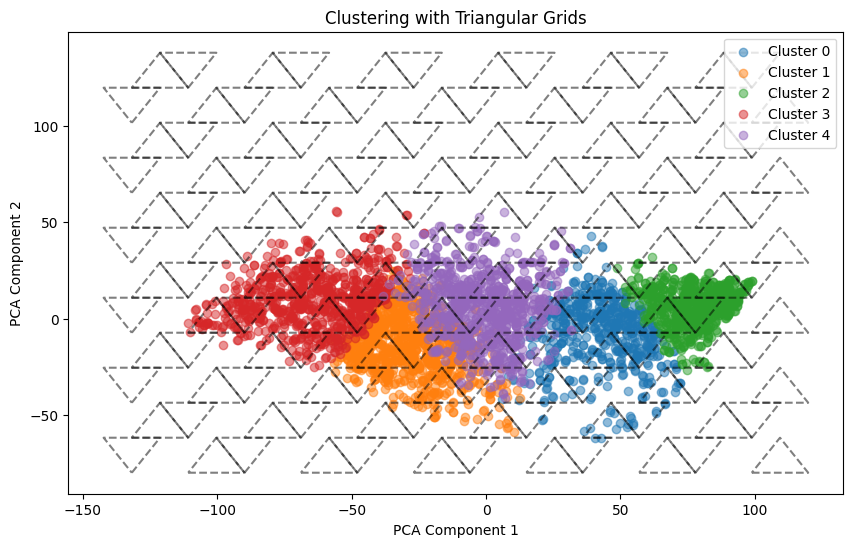

Epoch 1/10, Loss: 1.5053358793258667
Epoch 2/10, Loss: 1.24067347129186
Epoch 3/10, Loss: 1.0989476108551026
Epoch 4/10, Loss: 0.9246748201052348
Epoch 5/10, Loss: 0.6817302950223287
Epoch 6/10, Loss: 0.40236232995986937
Epoch 7/10, Loss: 0.22561992436647416
Epoch 8/10, Loss: 0.12138698641210795
Epoch 9/10, Loss: 0.06837890025538702
Epoch 10/10, Loss: 0.050737234394376475
Distilled Model Accuracy: 71.8%


In [11]:
# Distill the model with triangular distillation and evaluate
triangle_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=5, n_samples=100)
triangle_sampler.cluster_images()
triangle_sampler.plot_clusters_with_triangles()
selected_samples = triangle_sampler.get_selected_samples()

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)

print(f'Distilled Model Accuracy: {accuracy}%')
# m s - Distilled Model Accuracy: %

## Brick Distillation

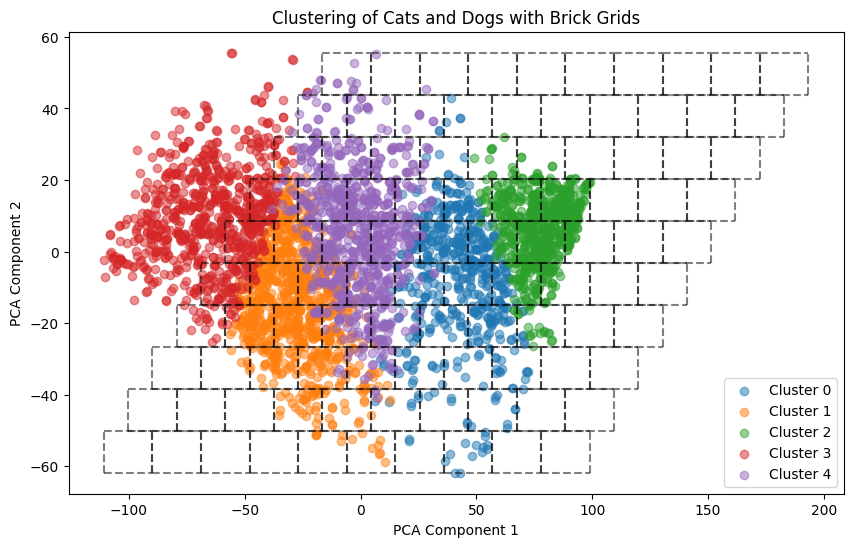

Epoch 1/10, Loss: 1.3154179906845094
Epoch 2/10, Loss: 0.9862675984700521
Epoch 3/10, Loss: 0.6835442340373993
Epoch 4/10, Loss: 0.3689064367612203
Epoch 5/10, Loss: 0.22651375989119213
Epoch 6/10, Loss: 0.11676475356022517
Epoch 7/10, Loss: 0.06998122374837597
Epoch 8/10, Loss: 0.026439907557020585
Epoch 9/10, Loss: 0.029777406404415768
Epoch 10/10, Loss: 0.012389175908950468
Distilled Model Accuracy: 69.3%


In [12]:
# Distill the model with brick distillation and evaluate
brick_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=5, n_samples=100)
brick_sampler.cluster_images()
brick_sampler.plot_clusters_with_bricks()
selected_samples = brick_sampler.get_selected_samples()

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')
# m s - Distilled Model Accuracy: %

# Demo - Gender

In [13]:
# define the dataset 
gender = ["MEN", "WOMAN"]
path = 'C:\\Users\\Hp\\summer_projects\\datasets\\gender\\'

# load the dataset
dataset = []
for i, gen in enumerate(gender):
    print(f'Processing {gen} images...')
    gen_dir = os.path.join(path, gen)
    for file in os.listdir(gen_dir):
        image_path = os.path.join(gen_dir, file)
        image = Image.open(image_path)
        image = image.resize((128, 128))  # Resize images to (128, 128)
        dataset.append((np.array(image), i))

# Shuffle the dataset
np.random.shuffle(dataset)

# Split the dataset into images and labels
X = np.array([x[0] for x in dataset], dtype=np.float32) / 255.0
y = np.array([x[1] for x in dataset], dtype=np.int64)

# Convert images to torch tensors
X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # Reshape to (N, C, H, W)
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, criterion, optimizer, epochs=10)

# Evaluate the model
accuracy = evaluate(model, test_loader)

print(f'Original Model Accuracy: {accuracy}%')



Processing MEN images...
Processing WOMAN images...
Epoch 1/10, Loss: 0.7610211119507299
Epoch 2/10, Loss: 0.5978706641630693
Epoch 3/10, Loss: 0.5438766280810038
Epoch 4/10, Loss: 0.5103301956798091
Epoch 5/10, Loss: 0.45102360663991986
Epoch 6/10, Loss: 0.40992212927702704
Epoch 7/10, Loss: 0.3229752490014741
Epoch 8/10, Loss: 0.27244084125215356
Epoch 9/10, Loss: 0.20303850417787378
Epoch 10/10, Loss: 0.11815027012066408
Original Model Accuracy: 71.81467181467181%


## Grid Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


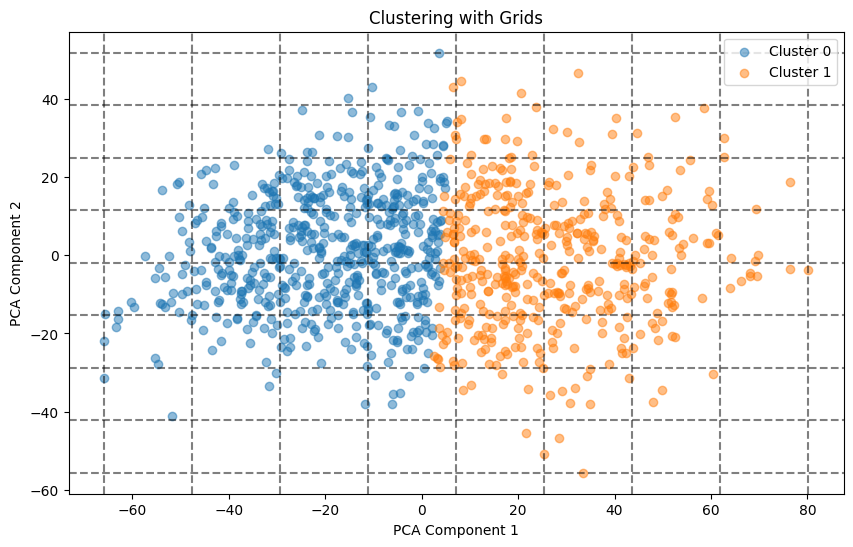

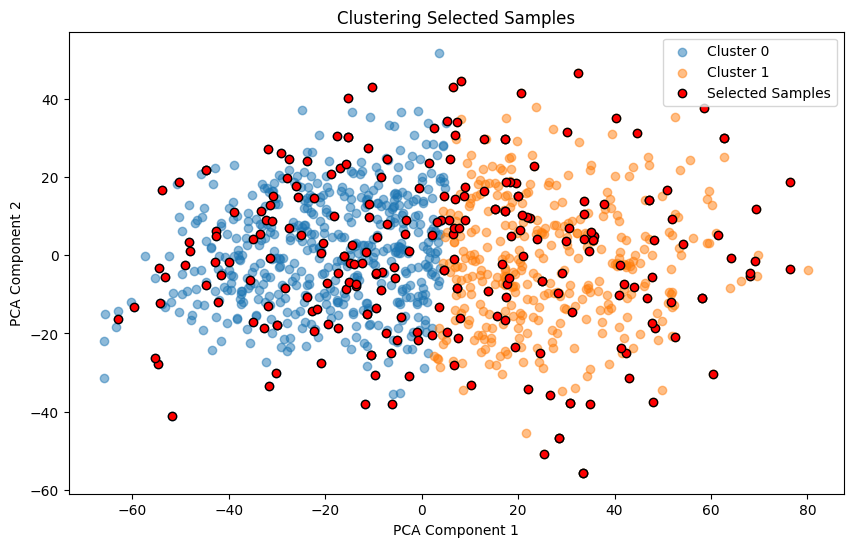

Epoch 1/10, Loss: 1.124449945986271
Epoch 2/10, Loss: 0.6972486972808838
Epoch 3/10, Loss: 0.6928674131631851
Epoch 4/10, Loss: 0.6895671188831329
Epoch 5/10, Loss: 0.6843922585248947
Epoch 6/10, Loss: 0.663700520992279
Epoch 7/10, Loss: 0.62513168156147
Epoch 8/10, Loss: 0.5583505034446716
Epoch 9/10, Loss: 0.4921014755964279
Epoch 10/10, Loss: 0.4339095838367939
Distilled Model Accuracy: 67.95366795366796%


In [17]:
# use grid distillation to distill the model
grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=2, n_samples=60)
grid_sampler.cluster_images()
grid_sampler.plot_clusters_with_grids()
selected_samples = grid_sampler.get_selected_samples()
grid_sampler.plot_selected_samples_on_clusters(selected_samples)


X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')


## Paralelogram Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


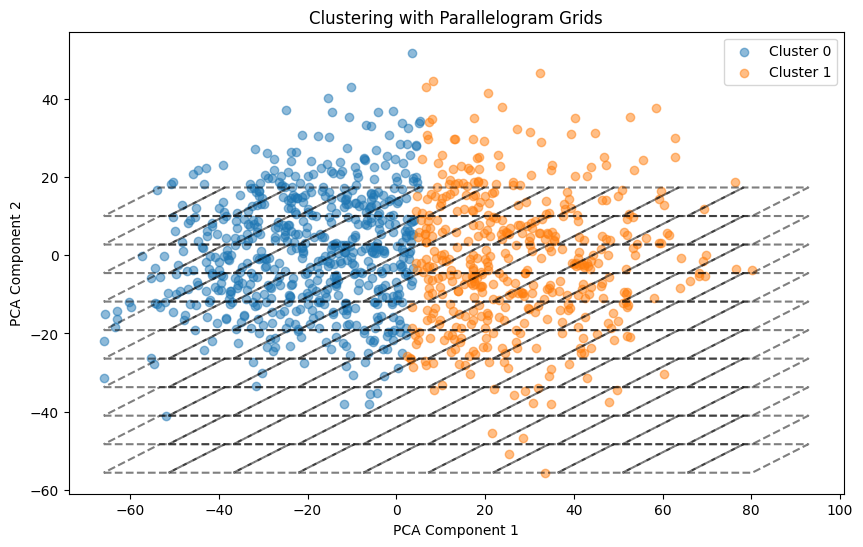

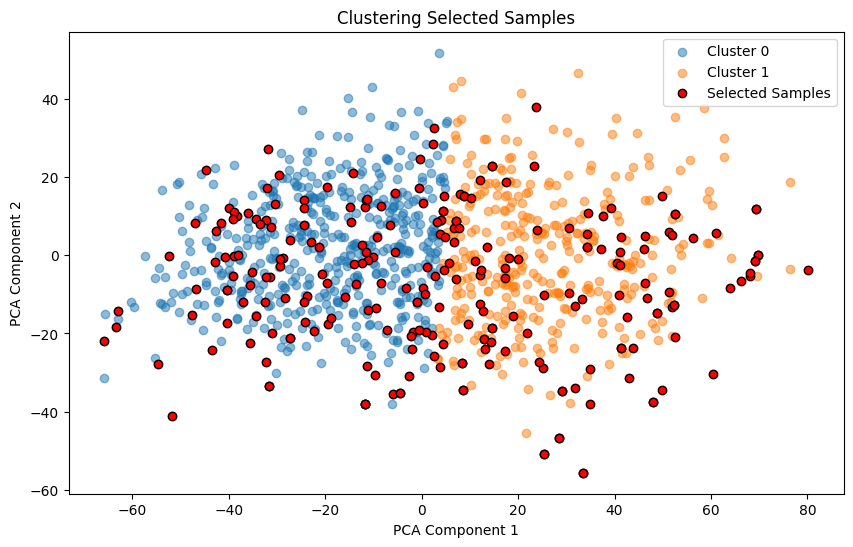

Epoch 1/10, Loss: 1.1794651299715042
Epoch 2/10, Loss: 0.6889168173074722
Epoch 3/10, Loss: 0.6796456351876259
Epoch 4/10, Loss: 0.6551270037889481
Epoch 5/10, Loss: 0.6000876799225807
Epoch 6/10, Loss: 0.5358119085431099
Epoch 7/10, Loss: 0.4068591743707657
Epoch 8/10, Loss: 0.3611922971904278
Epoch 9/10, Loss: 0.29049076698720455
Epoch 10/10, Loss: 0.2177198827266693
Distilled Model Accuracy: 63.706563706563706%


In [18]:
# use parallelogram distillation to distill the model
parallelogram_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=2, n_samples=60)
parallelogram_sampler.cluster_images()
parallelogram_sampler.plot_clusters_with_parallelograms()
selected_samples = parallelogram_sampler.get_selected_samples()
parallelogram_sampler.plot_selected_samples_on_clusters(selected_samples)

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')

## Triangular Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


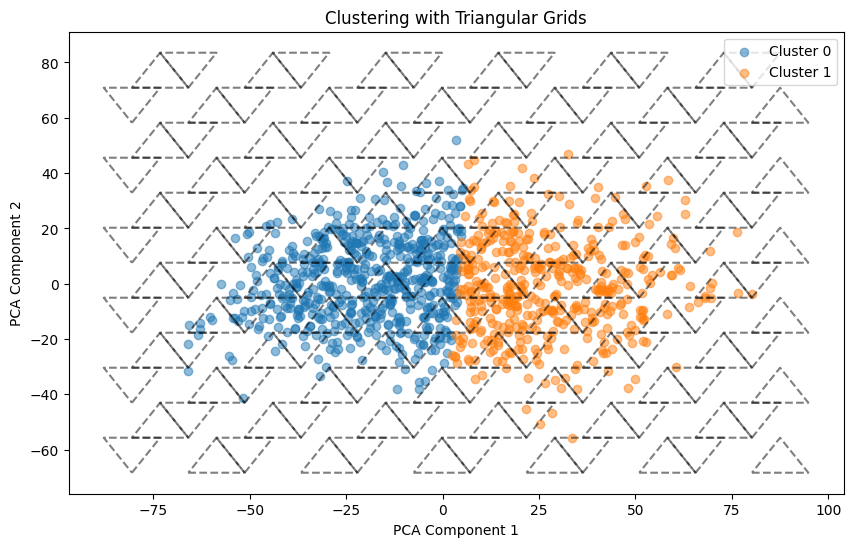

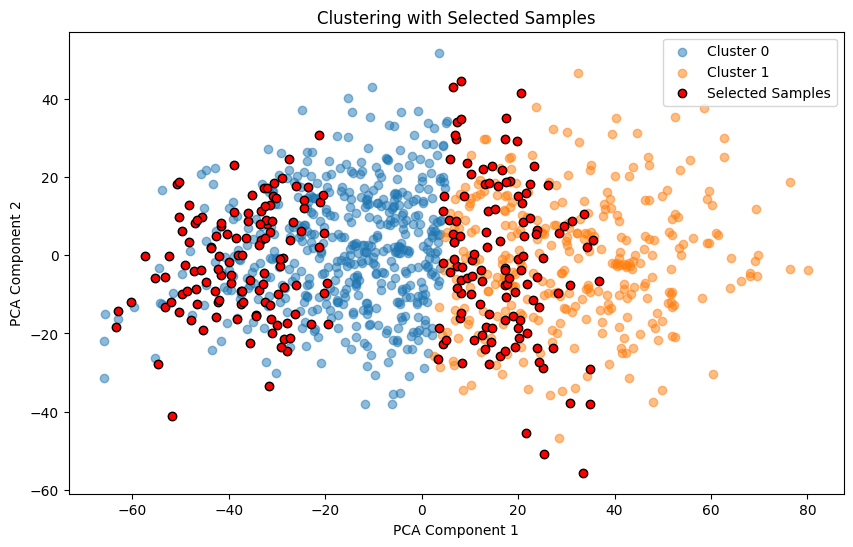

Epoch 1/10, Loss: 0.8456125110387802
Epoch 2/10, Loss: 0.6972123757004738
Epoch 3/10, Loss: 0.6940954551100731
Epoch 4/10, Loss: 0.6892006993293762
Epoch 5/10, Loss: 0.6590051054954529
Epoch 6/10, Loss: 0.6072384603321552
Epoch 7/10, Loss: 0.5707255974411964
Epoch 8/10, Loss: 0.49472976475954056
Epoch 9/10, Loss: 0.4491139091551304
Epoch 10/10, Loss: 0.3691287524998188
Distilled Model Accuracy: 66.79536679536679%


In [19]:
# use triangular distillation to distill the model
triangle_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=2, n_samples=60)
triangle_sampler.cluster_images()
triangle_sampler.plot_clusters_with_triangles()
selected_samples = triangle_sampler.get_selected_samples()
triangle_sampler.plot_selected_samples_on_clusters(selected_samples)

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')

## Brick Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


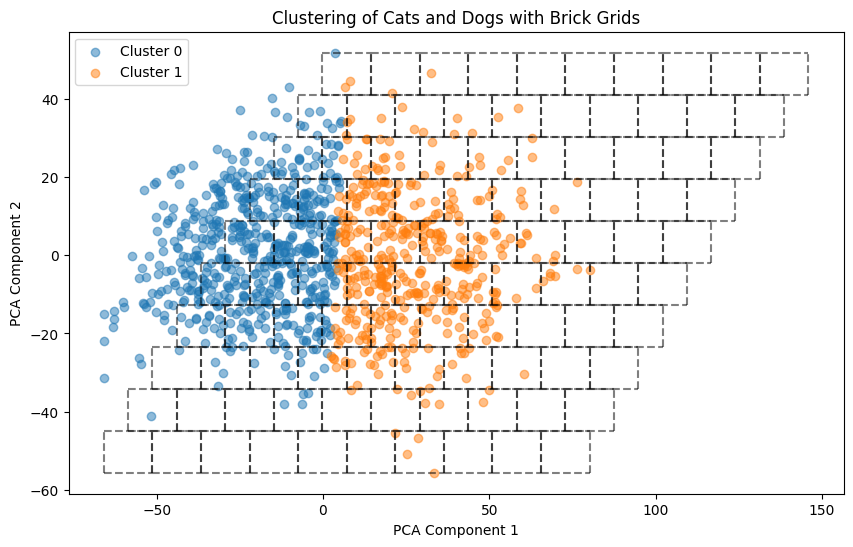

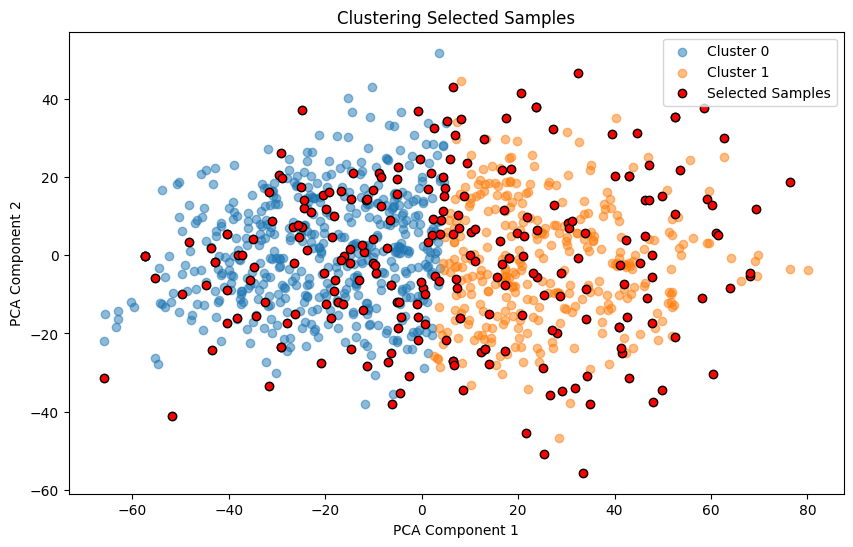

Epoch 1/10, Loss: 0.8213559314608574
Epoch 2/10, Loss: 0.6807664558291435
Epoch 3/10, Loss: 0.6903588324785233
Epoch 4/10, Loss: 0.6071075350046158
Epoch 5/10, Loss: 0.5208130367100239
Epoch 6/10, Loss: 0.5054406598210335
Epoch 7/10, Loss: 0.401768084615469
Epoch 8/10, Loss: 0.31506212428212166
Epoch 9/10, Loss: 0.2597092781215906
Epoch 10/10, Loss: 0.21920350193977356
Distilled Model Accuracy: 73.74517374517374%


In [20]:
# use brick distillation to distill the model
brick_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=2, n_samples=60)
brick_sampler.cluster_images()
brick_sampler.plot_clusters_with_bricks()
selected_samples = brick_sampler.get_selected_samples()
brick_sampler.plot_selected_samples_on_clusters(selected_samples)

X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

train_distilled_dataset = TensorDataset(X_train_distilled, y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {accuracy}%')